In [1]:
import pickle as p
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
from tqdm import tqdm
import scipy.signal as sig
from sklearn.linear_model import LogisticRegression
from scipy.interpolate import interp1d
from scipy.integrate import romb
plt.rcParams.update({'font.size': 22})
import glob
from scipy.signal import medfilt,butter
import scipy
import math

In [2]:
n_splits = 10
all_subjects = np.concatenate((np.arange(11,25),np.arange(26,45)))

def num_to_epoch(epoch_number):
    if epoch_number == 0:
        return 'UP1'
    elif epoch_number == 1:
        return 'UP2'
    elif epoch_number == 2:
        return 'P1'
    elif epoch_number == 3:
        return 'P2'
    elif epoch_number == 4:
        return 'REC'
    else:
        raise Exception('Invalid Epoch Number')

def num_to_subject(subject_number):
    return 'Subject'+str(subject_number)

def get_signal(measure, epoch, subjno):
    if isinstance(epoch,str):
        return np.ravel(df.loc[measure, epoch][num_to_subject(subjno)])
    elif isinstance(epoch, int):
        return np.ravel(df.loc[measure, num_to_epoch(epoch)][num_to_subject(subjno)])

def get_split_signal(measure, epoch, subjno, splitno):
    if isinstance(epoch,str):
        return np.array_split(np.ravel(df.loc[measure, epoch][num_to_subject(subjno)]), n_splits)[splitno]
    elif isinstance(epoch, int):
        return np.array_split(np.ravel(df.loc[measure, num_to_epoch(epoch)][num_to_subject(subjno)]),n_splits)[splitno]
    
def full_signal(measure, subjno):
    return np.concatenate((
        np.ravel(df.loc[measure, num_to_epoch(0)][num_to_subject(subjno)]),
        np.ravel(df.loc[measure, num_to_epoch(1)][num_to_subject(subjno)]),
        np.ravel(df.loc[measure, num_to_epoch(2)][num_to_subject(subjno)]),
        np.ravel(df.loc[measure, num_to_epoch(3)][num_to_subject(subjno)]),
        np.ravel(df.loc[measure, num_to_epoch(4)][num_to_subject(subjno)]),
    ))

def is_perturbed(epoch):
    if epoch == 0 or epoch == 1 or epoch == 4:
        return 0
    elif epoch == 2 or epoch == 3:
        return 1
    
def scaled_correlation_time(signal1, signal2):
    signal1 = (signal1 - np.mean(signal1))/np.std(signal1)
    signal2 = (signal2 - np.mean(signal2))/np.std(signal2)
    acorr = np.correlate(signal1, signal2, mode='full')
    acorr = acorr[(acorr.size // 2 ):] / np.max(acorr)
#     plt.plot(acorr)
    tau = np.argmax([acorr < 1/np.exp(1)])
    return tau / len(acorr)

def correlation_integral(signal1, signal2):
    signal1 = (signal1 - np.mean(signal1))/np.std(signal1)
    signal2 = (signal2 - np.mean(signal2))/np.std(signal2)
    acorr = np.correlate(signal1, signal2, mode='full')
    acorr = acorr[(acorr.size // 2 ):] / np.max(acorr)
#     plt.plot(acorr)
    integral = np.trapz(acorr)
    return integral

def plot_full_experiment(measure, subjno):
    s1 = np.ravel(df.loc[measure, num_to_epoch(0)][num_to_subject(subjno)])
    s2 = np.ravel(df.loc[measure, num_to_epoch(1)][num_to_subject(subjno)])
    s3 = np.ravel(df.loc[measure, num_to_epoch(2)][num_to_subject(subjno)])
    s4 = np.ravel(df.loc[measure, num_to_epoch(3)][num_to_subject(subjno)])
    s5 = np.ravel(df.loc[measure, num_to_epoch(4)][num_to_subject(subjno)])
    fullsignal = np.concatenate((s1,s2,s3,s4,s5))
    plt.plot(fullsignal,'k',label = measure)
    plt.axvline(x = len(s1), color = 'k', linestyle = '--')
    plt.axvline(x = len(s1)+len(s2), color = 'k', linestyle = '--')
    plt.axvline(x = len(s1)+len(s2)+len(s3), color = 'k', linestyle = '--')
    plt.axvline(x = len(s1)+len(s2)+len(s3)+len(s4), color = 'k', linestyle = '--')
    plt.legend()

In [3]:
shimfiles = glob.glob('shimmerData/*/*')

In [4]:
def get_shimmer(subjno, part, epochno):
    epoch = num_to_epoch(epochno)
    if epoch == 'REC':
        epoch = 'Rec'
    elif epoch == 'P1':
        epoch = '_P1'
    elif epoch == 'P2':
        epoch = '_P2'
    
    for file in shimfiles:
        if str(subjno) in file and part in file and epoch in file:
            data = pd.read_csv(file, header = None)
    try:
        vectors = np.asarray(data[[1,2,3]])
    except:
        print('mising shimmer data. skipping...')
        return np.repeat(np.nan, 1000)
    mean = np.mean(vectors, axis = 0)
    std = np.std(vectors, axis = 0)
    
    vectors = (vectors - mean[np.newaxis,:])

    #plt.plot(vectors)
    
    z_vector = np.linalg.norm(vectors, axis = 1)

    return z_vector


In [5]:
def get_split_shimmer(subjno, part, epochno, splitno):

    z_vector = get_shimmer(subjno,part,epochno)

    return np.array_split(z_vector,n_splits)[splitno]


In [6]:
def signal_statistics(signal):
    mean = np.mean(signal)
    std = np.std(signal)
    skewness = stats.skew(signal)
    kurtosis = stats.kurtosis(signal)
    maximum = np.max(signal)
    minimum = np.min(signal)
    iqr = stats.iqr(signal)
    variation = stats.variation(signal)
    entropy = stats.entropy(np.abs(signal))
    corrtime = scaled_correlation_time(signal,signal)        
    return np.asarray([mean, std, skewness, kurtosis, maximum, minimum, iqr, variation, entropy, corrtime])

def spectrum_statistics(signal):
    
    fs,pxx = sig.periodogram(signal, fs = 50, nfft = 1000, scaling = 'density', detrend = 'constant')
    
#     plt.plot(fs,pxx)
    #plt.xlim(0,0.1)

    peak = fs[np.argmax(pxx)]
    peakmag = np.max(pxx)
    integral = np.trapz(pxx,fs)
    energy = np.dot(pxx,pxx)
    shannon = np.sum(pxx*np.log(1/pxx))
    normalized_spectrum = pxx / sum(pxx)  
    normalized_frequencies = np.linspace(0, 1, len(pxx))
    spectral_centroid = sum(normalized_frequencies * normalized_spectrum)/sum(normalized_spectrum)


    # Add wavelet analysis

    return [peak, peakmag, integral, energy, shannon, spectral_centroid]



In [7]:
test_signal = get_shimmer(42, 'body', 3)

In [8]:
def max_dists(signal, m):
    count = 0
    N = len(signal)
    max_dists = []
    while count < N-m-1:
        x_i = signal[count:count+m-1]
        x_j = signal[count+1:count+m]
        max_dists.append(scipy.spatial.distance.chebyshev(x_i, x_j))
        count += 1
    return max_dists


def approx_entropy(signal):
    N = len(signal)
    m = 2 #or 3 -- dimensionality? 
    r = 0.3
        
    
    def phi(m):
        d_func = max_dists(signal,m)
        C = []
        for i in d_func:
            if i <= r and i > 0:
                C.append(i/(N-m+1)) 
        return (N - m + 1.0)**(-1) * sum(np.log10(C))
    return (abs(phi(m)-phi(m+1)))


approx_entropy(test_signal)

0.2766343281788908

In [9]:

def sample_entropy(signal):
    N = len(signal)
    m = 2
    r = 0.2
    
    A_list = max_dists(signal,m+1)
    B_list = max_dists(signal,m)
    
    count_A = 0
    count_B = 0
    for i in A_list:
        if i < r:
            count_A += 1
    for i in B_list: 
        if i < r:
            count_B += 1
    if count_B == 0:
        return np.nan
    return math.log10(count_A/count_B)*-1

print(sample_entropy(test_signal))

0.009862868702608938


In [10]:
def multiscale_entropy(signal):
    mses = []
    for T in range(2,20,2):
        coarse_grain = []
        i = 0
        while i < len(signal):
            new_val = sum(signal[i:i+T])/T
            coarse_grain.append(new_val)
            i += T
        mses.append(sample_entropy(coarse_grain))
    return np.mean(mses)
        
print(multiscale_entropy(test_signal))



0.024643562693091963


In [11]:
import nolds

In [12]:
from scipy.integrate import odeint

In [13]:
rho = 28.0
sigma = 10.0
beta = 8.0 / 3.0

def f(state, t):
    x, y, z = state  # Unpack the state vector
    return sigma * (y - x), x * (rho - z) - y, x * y - beta * z  # Derivatives

state0 = [1.0, 1.0, 1.0]
t = np.arange(0.0, 40.0, 0.1)

states = odeint(f, state0, t)

In [14]:
signal  = states[:,0]

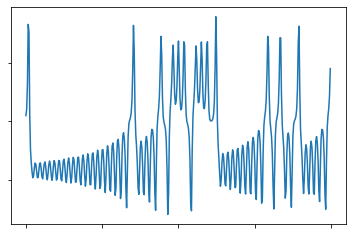

In [328]:
plt.plot(signal)

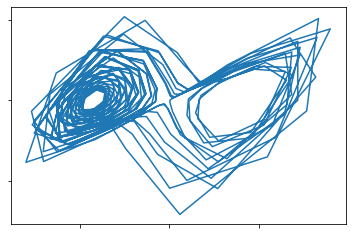

In [329]:
plt.plot(signal[1:], np.diff(signal))

In [345]:
len(signal)

400

In [370]:
tau = np.argmax(delay.acorr(test_signal) < 1 / np.e)

In [346]:
#def corr_dim(signal1)

In [347]:
from nolitsa import delay

In [363]:
def fnn(signal, tau = None, max_m = 10):
    fnns = [];
    if tau is None:
        tau = np.argmax(delay.acorr(signal) < 1 / np.e)

    for m in tqdm(range(1,max_m + 1)):

        N2 = len(signal) - tau*(m-1);
        xe = [];
        for mi in np.arange(m):
            xe.append(signal[(np.arange(N2) + tau * (mi-1))]);
        Rtol = 15;
        falsecount = 0;
        xe = np.asarray(xe).T
        for i in np.arange(len(xe[:,0])-1): #check minus 1
            Rdmin = 1000;
            for j in np.arange(len(xe[:,0])-1):

                Rd = scipy.linalg.norm(xe[i,:]-xe[j,:]);

                if j == i:
                    continue;
                elif Rd < Rdmin:
                    idx = j;
                    Rdmin = Rd;
            j = idx;
            Rdnext =  scipy.linalg.norm(xe[i+1,:]-xe[j+1,:]);
            Rd = scipy.linalg.norm(xe[i,:]-xe[j,:]);
            if Rd == 0:
                continue
            R = Rdnext/Rd;
            if R > Rtol:
                falsecount = falsecount + 1;    
        fnnprop = falsecount/len(xe[:,0]);
        fnns.append(fnnprop)

        if fnnprop < 0.005:
            break
    
    return fnns
#emdim = find(fnns < 0.01,1);

In [ ]:

#Frequency domain analysis: spectral flux
signal = get_shimmer(28, 'body', 1)

def spectral_flux(signal, nsplits):
    window = len(signal)//nsplits
    sig_list = []
    i = 0
    while i < len(signal):
        fs, fourier_sig = sig.periodogram(signal[i:i+window], scaling = 'density')
        sig_list.append(fourier_sig)
        i = i+window
    flux = []
    for j in range(0,len(sig_list)-2):
        norm_window = sig_list[j]/sum(sig_list[j])
        prev_window = sig_list[j+1]/sum(sig_list[j+1])
        flux.append(sum((norm_window-prev_window)**2))
    return [np.mean(flux), np.std(flux)]

def flux_stats(signal):
    fluxmeans = []
    fluxstds = []
    n = range(2,500,10)
    for i in range(2,500,10):
        nsplits = i
        mean, std = spectral_flux(signal, nsplits)
        fluxmeans.append(mean)
        fluxstds.append(std)

    full_mean_slope, full_mean_int, full_mean_r, full_mean_p, full_mean_std_err = stats.linregress(n, fluxmeans)
    full_std_slope, full_std_int, full_std_r, full_std_p, full_std_err = stats.linregress(n, fluxstds)
    half_mean_slope, half_mean_int, half_mean_r, half_mean_p, half_mean_std_err = stats.linregress(n[25:], fluxmeans[25:])
    half_std_slope, half_std_int, half_std_r, half_std_p, half_std_err = stats.linregress(n[25:], fluxstds[25:])
    maximum = max(fluxmeans)
    minimum = min(fluxmeans)
    integral = np.trapz(fluxmeans,n)
    return [maximum, minimum, integral, full_mean_slope, full_mean_int, full_std_slope, full_std_int, half_mean_slope, half_mean_int, half_std_slope, half_std_int, full_mean_r, full_std_r]
flux_stats(signal)


In [406]:
bfeatures = [];
n_splits = 1
targets = [];
allfeatures = []
hfeatures = [];

for subjno in tqdm(all_subjects):
    for epoch in range(4):
        for splitno in range(n_splits):
            
            bshim_signal = get_split_shimmer(subjno,'body',epoch,splitno)
            if np.isnan(bshim_signal[0]):
                continue;
                
            start = int(len(bshim_signal)/2)
            bfeature = np.stack((approx_entropy(bshim_signal), sample_entropy(bshim_signal), \
                    multiscale_entropy(bshim_signal), nolds.corr_dim(bshim_signal[start:(start+1000)], 4)))
            bfeatures.append(bfeature)

            hshim_signal = get_split_shimmer(subjno,'head',epoch,splitno)
            if np.isnan(hshim_signal[0]):
                continue;
            hfeature = np.stack((approx_entropy(hshim_signal), sample_entropy(hshim_signal), \
                multiscale_entropy(hshim_signal), nolds.corr_dim(hshim_signal[start:(start+1000)], 4)))
            hfeatures.append(hfeature)

            targets.append(is_perturbed(epoch))
            allfeature = np.concatenate((bfeature,hfeature))
            allfeatures.append(allfeature)

allfeature_names = ['b_approx_entropy', 'b_sample_entropy', 'b_multiscale_entropy', 'b_corrdim', \
                   'h_approx_entropy', 'h_sample_entropy', 'h_multiscale_entropy', 'h_corrdim']
fdf = pd.DataFrame(allfeatures, columns = allfeature_names)







  0%|          | 0/33 [00:00<?, ?it/s]




  3%|▎         | 1/33 [00:56<30:23, 56.98s/it]




  6%|▌         | 2/33 [01:56<29:51, 57.81s/it]

mising shimmer data. skipping...
mising shimmer data. skipping...
mising shimmer data. skipping...
mising shimmer data. skipping...
mising shimmer data. skipping...
mising shimmer data. skipping...
mising shimmer data. skipping...
mising shimmer data. skipping...







 15%|█▌        | 5/33 [02:55<21:37, 46.32s/it]




 18%|█▊        | 6/33 [03:54<22:34, 50.16s/it]

mising shimmer data. skipping...
mising shimmer data. skipping...
mising shimmer data. skipping...
mising shimmer data. skipping...







 24%|██▍       | 8/33 [04:35<17:11, 41.26s/it]




 27%|██▋       | 9/33 [05:34<18:35, 46.46s/it]

mising shimmer data. skipping...
mising shimmer data. skipping...
mising shimmer data. skipping...







 30%|███       | 10/33 [06:02<15:47, 41.18s/it]

mising shimmer data. skipping...
mising shimmer data. skipping...
mising shimmer data. skipping...
mising shimmer data. skipping...







 33%|███▎      | 11/33 [06:31<13:41, 37.35s/it]

mising shimmer data. skipping...







 36%|███▋      | 12/33 [07:24<14:45, 42.17s/it]




 39%|███▉      | 13/33 [08:20<15:23, 46.19s/it]




 42%|████▏     | 14/33 [09:16<15:37, 49.32s/it]




 45%|████▌     | 15/33 [10:15<15:36, 52.01s/it]




 48%|████▊     | 16/33 [11:09<14:57, 52.80s/it]




 52%|█████▏    | 17/33 [12:06<14:24, 54.00s/it]




 55%|█████▍    | 18/33 [13:05<13:49, 55.32s/it]




 58%|█████▊    | 19/33 [14:05<13:17, 56.93s/it]




 61%|██████    | 20/33 [15:03<12:24, 57.31s/it]




 64%|██████▎   | 21/33 [16:04<11:39, 58.25s/it]




 67%|██████▋   | 22/33 [17:05<10:50, 59.12s/it]




 70%|██████▉   | 23/33 [18:06<09:56, 59.69s/it]




 73%|███████▎  | 24/33 [19:25<09:48, 65.40s/it]




 76%|███████▌  | 25/33 [20:34<08:51, 66.42s/it]




 79%|███████▉  | 26/33 [21:35<07:34, 64.98s/it]




 82%|████████▏ | 27/33 [22:48<06:43, 67.21s/it]

mising shimmer data. skipping...
mising shimmer data. skipping...
mising shimmer data. skipping...







 85%|████████▍ | 28/33 [23:18<04:40, 56.06s/it]

mising shimmer data. skipping...







 88%|████████▊ | 29/33 [24:17<03:48, 57.05s/it]




 91%|█████████ | 30/33 [25:17<02:54, 58.02s/it]




 94%|█████████▍| 31/33 [26:16<01:56, 58.30s/it]




 97%|█████████▋| 32/33 [27:16<00:58, 58.68s/it]




100%|██████████| 33/33 [28:19<00:00, 51.51s/it]


In [408]:
targets = np.asarray(targets)
fdf = pd.DataFrame(allfeatures, columns = allfeature_names)

In [409]:
where = ~(np.asarray(np.sum(np.isnan(fdf),1)) > 0)

In [422]:
fdf_clean = fdf.iloc[where]
targets_clean = targets[where]

In [15]:
import pickle

In [16]:
arr = pickle.load(open('fdfclean.p', 'rb'))

In [18]:
fdf_clean = arr[0]
targets_clean = arr[1]

In [41]:
unpert = targets_clean == 0
pert = targets_clean == 1

In [43]:
fdf_corr = fdf_clean[['h_corrdim', 'b_corrdim']]

In [48]:
fdf_clean = fdf_clean.drop(['h_corrdim', 'b_corrdim'], axis = 1)

Text(0, 0.5, 'Entropy Measure')

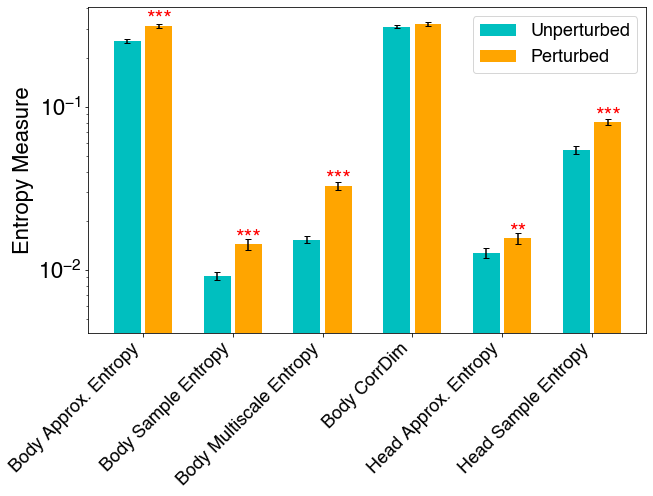

In [58]:
pvals = [];

for measure in fdf_clean.columns:
    unpert_measure = np.asarray(fdf_clean.iloc[unpert][measure])
    pert_measure = np.asarray(fdf_clean.iloc[pert][measure])
    pvals.append(stats.wilcoxon(unpert_measure, pert_measure).pvalue)

import statsmodels.stats.multitest as multitest

bonf05 = multitest.multipletests(pvals, alpha = 0.05, method = 'bonferroni')[0]
bonf01 = multitest.multipletests(pvals, alpha = 0.01, method = 'bonferroni')[0]
bonf1 = multitest.multipletests(pvals, alpha = 0.1, method = 'bonferroni')[0]

aster_n = bonf05.astype(int) + bonf01.astype(int) + bonf1.astype(int)

def n_to_str(n):
    if n == 0:
        return ''
    if n == 1:
        return '*'
    if n == 2:
        return '**'
    if n == 3:
        return '***'

u_means = np.mean(fdf_clean[unpert], 0)
u_stds = stats.sem(fdf_clean[unpert], 0)
p_means = np.mean(fdf_clean[pert], 0)
p_stds = stats.sem(fdf_clean[pert], 0)

plt.figure(figsize = (10,6))
idx = np.arange(len(fdf_clean.columns))
width = 0.3
plt.bar(idx, height = u_means, yerr = u_stds, log = True, width = width, capsize = 3, color = 'c',\
       label = 'Unperturbed');
plt.bar(idx + width + 0.05, height = p_means, yerr = p_stds, log = True, width = width, capsize = 3, \
        color = 'orange', label = 'Perturbed');

labels = ['Body Approx. Entropy', 'Body Sample Entropy', 'Body Multiscale Entropy', 'Body CorrDim',\
             'Head Approx. Entropy', 'Head Sample Entropy', 'Head Multiscale Entropy', 'Head Corrdim']
plt.xticks(idx+0.5*(width + 0.05), labels, rotation=45, ha='right',fontsize=18);

for ii in range(len(fdf_clean.columns)):
    plt.text(idx[ii] + width + .05, p_means[ii], n_to_str(aster_n[ii]), ha = 'center', color = 'r');

plt.legend(fontsize = 18)
plt.ylabel('Entropy Measure')

#plt.savefig('entropy_measures.pdf', bbox_inches = 'tight')

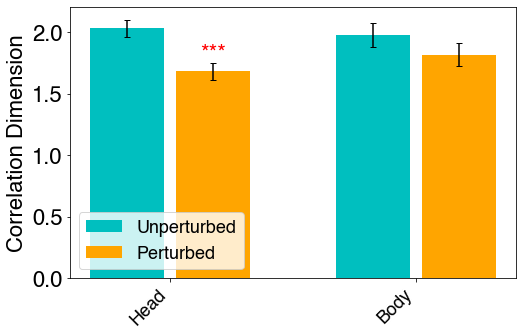

In [71]:
pvals = [];

for measure in fdf_corr.columns:
    unpert_measure = np.asarray(fdf_corr.iloc[unpert][measure])
    pert_measure = np.asarray(fdf_corr.iloc[pert][measure])
    pvals.append(stats.wilcoxon(unpert_measure, pert_measure).pvalue)

import statsmodels.stats.multitest as multitest

bonf05 = multitest.multipletests(pvals, alpha = 0.05, method = 'bonferroni')[0]
bonf01 = multitest.multipletests(pvals, alpha = 0.01, method = 'bonferroni')[0]
bonf1 = multitest.multipletests(pvals, alpha = 0.1, method = 'bonferroni')[0]

aster_n = bonf05.astype(int) + bonf01.astype(int) + bonf1.astype(int)

def n_to_str(n):
    if n == 0:
        return ''
    if n == 1:
        return '*'
    if n == 2:
        return '**'
    if n == 3:
        return '***'

u_means = np.mean(fdf_corr[unpert], 0)
u_stds = stats.sem(fdf_corr[unpert], 0)
p_means = np.mean(fdf_corr[pert], 0)
p_stds = stats.sem(fdf_corr[pert], 0)

plt.figure(figsize = (8,5))
idx = np.arange(len(fdf_corr.columns))
width = 0.3
plt.bar(idx, height = u_means, yerr = u_stds, log = False, width = width, capsize = 3, color = 'c',\
       label = 'Unperturbed');
plt.bar(idx + width + 0.05, height = p_means, yerr = p_stds, log = False, width = width, capsize = 3, \
        color = 'orange', label = 'Perturbed');

labels = ['Head','Body']
plt.xticks(idx+0.5*(width + 0.05), labels, rotation=45, ha='right',fontsize=18);

for ii in range(len(fdf_corr.columns)):
    plt.text(idx[ii] + width + .05, p_means[ii] + 0.1, n_to_str(aster_n[ii]), ha = 'center', color = 'r');

plt.legend(fontsize = 18)
plt.ylabel('Correlation Dimension')

plt.savefig('corr_measures.pdf', bbox_inches = 'tight')